Model Accuracy: 0.35
                        AAPL  holdings      cash     total   returns
2024-01-26 19:59:00  19228.0   19228.0  100000.0  119228.0       NaN
2024-01-26 19:58:00      0.0       0.0  119226.0  119226.0 -0.000017
2024-01-26 19:57:00  19222.5   19222.5  100003.5  119226.0  0.000000
2024-01-26 19:56:00      0.0       0.0  119235.5  119235.5  0.000080
2024-01-26 19:55:00  19230.0   19230.0  100005.5  119235.5  0.000000


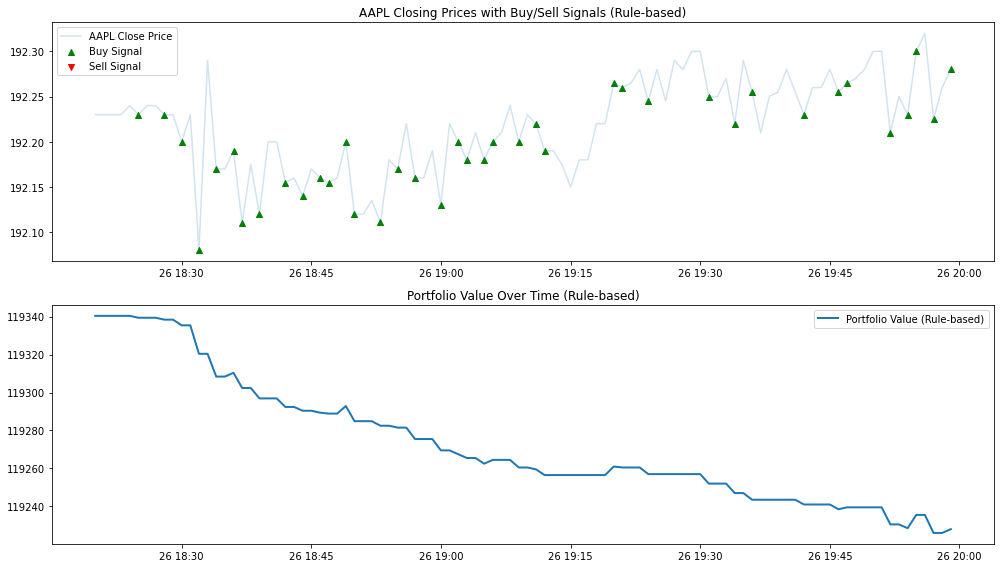

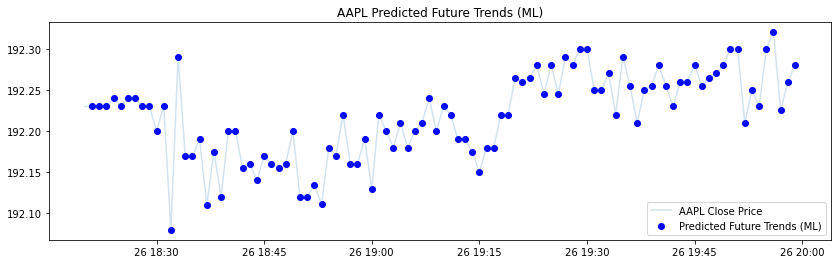

In [17]:
import pandas as pd
import numpy as np
import requests
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Replace 'YOUR_API_KEY' with your actual Alpha Vantage API key
api_key = "YOUR_API_KEY"
symbol = 'AAPL'
interval = '1min'

# Phase 1: Data Acquisition
def fetch_alpha_vantage_data(api_key, symbol, interval):
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={symbol}&interval={interval}&apikey={api_key}'
    try:
        response = requests.get(url)
        data = response.json()
        
        if 'Time Series (1min)' not in data:
            raise ValueError("Data not available for the given symbol and interval.")
        
        # Extract relevant data from the API response
        ohlc_data = data['Time Series (1min)']
        ohlc_df = pd.DataFrame(ohlc_data).T
        ohlc_df.index = pd.to_datetime(ohlc_df.index)

        # Extract relevant columns and convert them to numeric
        ohlc_df = ohlc_df[['1. open', '2. high', '3. low', '4. close', '5. volume']]
        ohlc_df.columns = ['open', 'high', 'low', 'close', 'volume']
        ohlc_df = ohlc_df.apply(pd.to_numeric, errors='coerce')

        return ohlc_df
    
    except requests.exceptions.RequestException as e:
        print(f"Error during API request: {e}")
        return None
    except Exception as e:
        print(f"Error: {e}")
        return None

# Phase 2: Data Preprocessing (Not explicitly shown in this example)
# You may preprocess data as needed for your specific strategy

# Phase 3: Machine Learning Model
def generate_signals_ml(data):
    # Create features (X) and target variable (y)
    X = data[['open', 'high', 'low', 'volume']]
    y = np.where(data['close'].shift(-1) > data['close'], 1, 0)  # Binary classification: 1 if next close price is higher, else 0

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create a Random Forest Classifier
    model = RandomForestClassifier(n_estimators=100, random_state=42)

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate accuracy on the test set
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Model Accuracy: {accuracy}')

    # Generate signals based on model predictions
    signals = pd.DataFrame(index=data.index)
    signals['signal'] = model.predict(X)
    signals['positions'] = signals['signal'].diff()

    return signals

# Phase 4: Backtesting
def backtest_strategy(data, signals):
    # Assuming initial capital is 100,000 units of currency
    initial_capital = 100000.0
    positions = pd.DataFrame(index=signals.index).fillna(0.0)

    # Buy signal: 1.0, Sell signal: -1.0
    positions['AAPL'] = 100 * signals['signal']   # Buy 100 shares on a Buy signal
    portfolio = positions.multiply(data['close'], axis=0)
    pos_diff = positions.diff()

    # Add cash holdings (subtracting transaction costs)
    portfolio['holdings'] = (positions.multiply(data['close'], axis=0)).sum(axis=1)
    portfolio['cash'] = initial_capital - (pos_diff.multiply(data['close'], axis=0)).sum(axis=1).cumsum()

    # Calculate total portfolio value
    portfolio['total'] = portfolio['cash'] + portfolio['holdings']

    # Calculate daily returns
    portfolio['returns'] = portfolio['total'].pct_change()

    return portfolio

# Phase 5: Visualization
def plot_results(data, signals, portfolio, signals_ml, future_predictions=None):
    # Plotting Closing Prices and Buy/Sell signals
    plt.figure(figsize=(14, 8))
    plt.subplot(2, 1, 1)
    plt.plot(data['close'], label='AAPL Close Price', alpha=0.2)

    # Plotting Buy and Sell signals based on rule-based strategy
    buy_signals = signals.loc[signals['signal'] == 1.0]
    sell_signals = signals.loc[signals['signal'] == -1.0]

    plt.scatter(buy_signals.index, data['close'][buy_signals.index], marker='^', color='g', label='Buy Signal')
    plt.scatter(sell_signals.index, data['close'][sell_signals.index], marker='v', color='r', label='Sell Signal')

    plt.title('AAPL Closing Prices with Buy/Sell Signals (Rule-based)')
    plt.legend()

    # Plotting Portfolio Value
    plt.subplot(2, 1, 2)
    plt.plot(portfolio['total'], label='Portfolio Value (Rule-based)', linewidth=2)
    plt.title('Portfolio Value Over Time (Rule-based)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Plotting Predicted Future Trends using machine learning
    plt.figure(figsize=(14, 4))
    plt.plot(data['close'], label='AAPL Close Price', alpha=0.2)
    plt.scatter(signals_ml.index, data['close'][signals_ml.index], marker='o', color='b', label='Predicted Future Trends (ML)')

    # Plotting Predictions for the Next Hour
    if future_predictions is not None:
        plt.scatter(future_predictions.index, future_predictions['predicted_close'], marker='x', color='m', label='Predicted Next Hour')

    plt.title('AAPL Predicted Future Trends (ML)')
    plt.legend()
    plt.show()

# Function to predict future prices for the next hour
def predict_future_prices(data):
    # In this example, let's assume a simple prediction by shifting the close prices
    future_prices = data['close'].shift(-1)
    future_prices = future_prices.dropna()  # Drop the last row with NaN
    future_predictions = pd.DataFrame(index=future_prices.index)
    future_predictions['predicted_close'] = future_prices
    return future_predictions

# Example Usage
# Example Usage
stock_data = fetch_alpha_vantage_data(api_key, symbol, interval)

if stock_data is not None:
    # Generate signals using machine learning
    signals_ml = generate_signals_ml(stock_data)

    # Backtest strategy
    portfolio_ml = backtest_strategy(stock_data, signals_ml)

    # Predict future prices for the next hour
    future_predictions = predict_future_prices(stock_data)

    # Print the portfolio summary
    print(portfolio_ml.head())

    # Visualize results
    plot_results(stock_data, signals_ml, portfolio_ml, future_predictions)
else:
    print("Data retrieval failed.")

